In [459]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from NODE_fns import forward_pass_nobias, forward_pass
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond, scan
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)
import pandas as pd

# from scipy.integrate import odeint

In [475]:
# Psi_EQ
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
NN_weights, alpha, Psi1_bias, Psi2_bias = Psi_eq_params
[I1_params, I2_params, J1_params] = NN_weights

In [521]:
t = np.linspace(0,1,51)
I1 = np.linspace(0,1,50)
I1 = np.exp(np.exp(np.exp(I1)))
I1 = (I1-np.min(I1))/np.max(I1)
I1 = np.hstack([I1, np.linspace(1,10,50)])

trajectories1 = []
for i in range(I1.shape[0]):
    y = I1[i]
    traj = [y]
    for j in range(50):
        y = y + forward_pass_nobias(np.array([y]), I1_params)[0]
        traj.append(y)
    trajectories1.append(traj)
trajectories1 = np.array(trajectories1)

x1max = 1
y1max = 45
x1,y1 = onp.meshgrid(onp.linspace(0,x1max,10),onp.linspace(0.1,y1max,10))
u1 = onp.ones_like(x1)
v1 = onp.zeros_like(x1)
for i in range(x1.shape[0]):
    for j in range(y1.shape[0]):
        v1[i,j] = forward_pass_nobias(np.array([y1[i,j]]), I1_params)[0]


In [565]:
I2 = np.linspace(0,10,30)

trajectories2 = []
for i in range(I2.shape[0]):
    y = I2[i]
    traj = [y]
    for j in range(50):
        y = y + forward_pass_nobias(np.array([y]), I2_params)[0]
        traj.append(y)
    trajectories2.append(traj)
trajectories2 = np.array(trajectories2)

x2max = 1
y2max = 2
x2,y2 = onp.meshgrid(onp.linspace(0,x2max,10),onp.linspace(0,y2max,10))
u2 = onp.ones_like(x2)
v2 = onp.zeros_like(x2)
for i in range(x2.shape[0]):
    for j in range(y2.shape[0]):
        v2[i,j] = forward_pass_nobias(np.array([y2[i,j]]), I2_params)[0] 

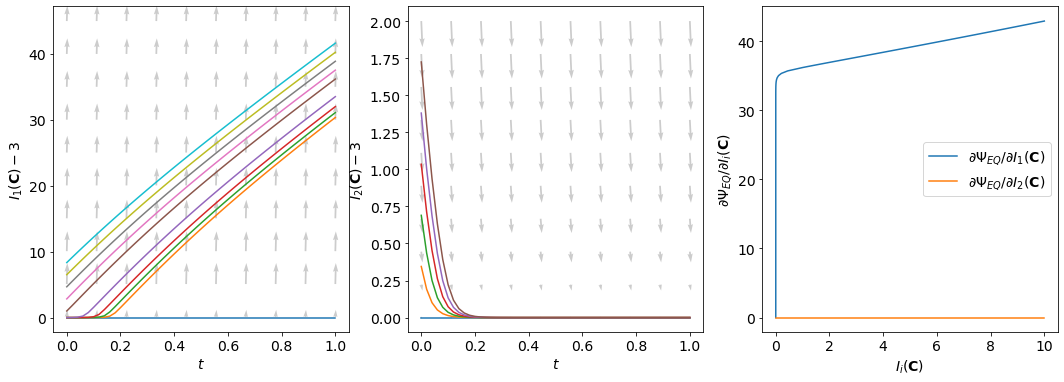

In [567]:
fig, ax = plt.subplots(1,3,figsize=[18,6])

ax[0].quiver(x1,y1,u1,v1, alpha=0.2) # I am not dividing u1 by 50 here because then the matplotlib quiver plot doesn't work, but I do it before saving for tikz.
for trajectory in trajectories1[::10]:
    ax[0].plot(t, trajectory)
ax[0].set(xlabel='$t$', ylabel='$I_1(\mathbf{C})-3$'); 

ax[1].quiver(x2,y2,u2/50,v2, alpha=0.2) #/50 Because I scaled the time down by a factor of 50, so I should do the same for the vertical axis.
for trajectory in trajectories2[:6]:
    ax[1].plot(t, trajectory)
ax[1].set(xlabel='$t$', ylabel='$I_2(\mathbf{C})-3$'); 

ax[2].plot(trajectories1[:,0], trajectories1[:,-1], label='$\partial \Psi_{EQ}/\partial I_1(\mathbf{C})$')
ax[2].plot(trajectories2[:,0], trajectories2[:,-1], label='$\partial \Psi_{EQ}/\partial I_2(\mathbf{C})$')
ax[2].set(xlabel='$I_i(\mathbf{C})$', ylabel='$\partial \Psi_{EQ}/\partial I_i(\mathbf{C})$')
ax[2].legend(); 

In [587]:
# Save for tikz

# Panel A
header1 = ['x', 'y', 'u', 'v']
a = np.array([x1.flatten(), y1.flatten(), u1.flatten()/50, v1.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_A_quiver.csv', index=False, sep=' ')

header2 = ['x']
for i in range(10):
    header2.append('y{}'.format(str(i)))
df = pd.DataFrame(np.array([t,*trajectories1[::10]]).T, columns=header2)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_A_curves.csv', index=False, sep=' ')

# Panel B
a = np.array([x2.flatten(), y2.flatten(), u2.flatten()/50, v2.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_B_quiver.csv', index=False, sep=' ')

df = pd.DataFrame(np.array([t,*trajectories2[:6]]).T, columns=header2[:7])
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_B_curves.csv', index=False, sep=' ')

# Panel C
header = ['x1', 'y1', 'x2', 'y2']
df = pd.DataFrame([trajectories1[:,0], trajectories1[:,-1], trajectories2[:,0], trajectories2[:,-1]]).T
df.columns = header
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_C.csv', index=False, sep=' ')

In [589]:
# Psi_NEQ
with open('saved/Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
NN_weights, alpha, Psi1_bias, Psi2_bias = Psi_neq_params
[I1_params, I2_params, J1_params] = NN_weights

In [602]:
I1 = np.linspace(0,1,10)
I1 = np.exp(np.exp(I1))
I1 = (I1-np.min(I1))/np.max(I1)
I1 = np.hstack([I1, np.array(1.0)])

trajectories1 = []
for i in range(I1.shape[0]):
    y = I1[i]
    traj = [y]
    for j in range(50):
        y = y + forward_pass_nobias(np.array([y]), I1_params)[0]
        traj.append(y)
    trajectories1.append(traj)
trajectories1 = np.array(trajectories1)

x1max = 1
y1max = 45
x1,y1 = onp.meshgrid(onp.linspace(0,x1max,10),onp.linspace(0,y1max,10))
u1 = onp.ones_like(x1)
v1 = onp.zeros_like(x1)
for i in range(x1.shape[0]):
    for j in range(y1.shape[0]):
        v1[i,j] = forward_pass_nobias(np.array([y1[i,j]]), I1_params)[0]

In [603]:
I2 = np.linspace(0,1,6)

trajectories2 = []
for i in range(I2.shape[0]):
    y = I2[i]
    traj = [y]
    for j in range(50):
        y = y + forward_pass_nobias(np.array([y]), I2_params)[0]
        traj.append(y)
    trajectories2.append(traj)
trajectories2 = np.array(trajectories2)

x2max = 1
y2max = 1
x2,y2 = onp.meshgrid(onp.linspace(0,x2max,10),onp.linspace(0,y2max,10))
u2 = onp.ones_like(x2)
v2 = onp.zeros_like(x2)
for i in range(x2.shape[0]):
    for j in range(y2.shape[0]):
        v2[i,j] = forward_pass_nobias(np.array([y2[i,j]]), I2_params)[0]

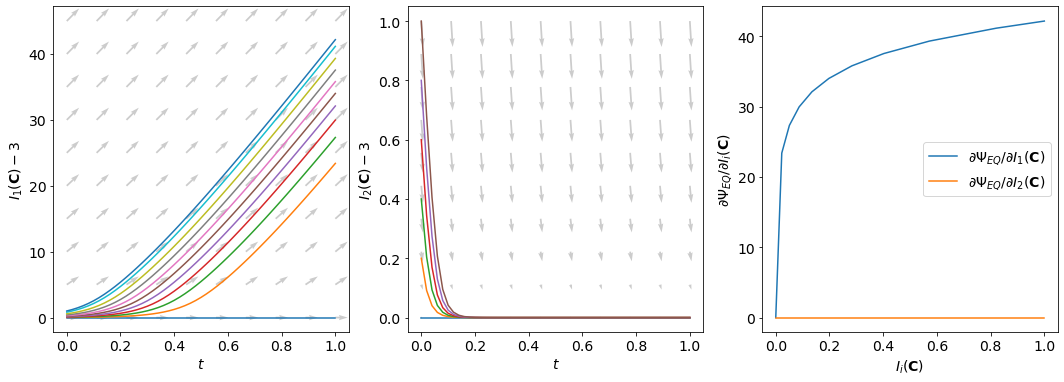

In [605]:
fig, ax = plt.subplots(1,3,figsize=[18,6])

ax[0].quiver(x1,y1,u1,v1, alpha=0.2)
for trajectory in trajectories1:
    ax[0].plot(t, trajectory)
ax[0].set(xlabel='$t$', ylabel='$I_1(\mathbf{C})-3$'); 

ax[1].quiver(x2,y2,u2/50,v2, alpha=0.2)
for trajectory in trajectories2:
    ax[1].plot(t, trajectory)
ax[1].set(xlabel='$t$', ylabel='$I_2(\mathbf{C})-3$'); 

ax[2].plot(trajectories1[:,0], trajectories1[:,-1], label='$\partial \Psi_{EQ}/\partial I_1(\mathbf{C})$')
ax[2].plot(trajectories2[:,0], trajectories2[:,-1], label='$\partial \Psi_{EQ}/\partial I_2(\mathbf{C})$')
ax[2].set(xlabel='$I_i(\mathbf{C})$', ylabel='$\partial \Psi_{EQ}/\partial I_i(\mathbf{C})$')
ax[2].legend(); 

In [606]:
# Save for tikz

# Panel A
header1 = ['x', 'y', 'u', 'v']
a = np.array([x1.flatten(), y1.flatten(), u1.flatten()/50, v1.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_D_quiver.csv', index=False, sep=' ')

header2 = ['x']
for i in range(11):
    header2.append('y{}'.format(str(i)))
df = pd.DataFrame(np.array([t,*trajectories1]).T, columns=header2)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_D_curves.csv', index=False, sep=' ')

# Panel B
a = np.array([x2.flatten(), y2.flatten(), u2.flatten()/50, v2.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_E_quiver.csv', index=False, sep=' ')

df = pd.DataFrame(np.array([t,*trajectories2[:6]]).T, columns=header2[:7])
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_E_curves.csv', index=False, sep=' ')

# Panel C
header = ['x1', 'y1', 'x2', 'y2']
df = pd.DataFrame([trajectories1[:,0], trajectories1[:,-1], trajectories2[:,0], trajectories2[:,-1]]).T
df.columns = header
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_F.csv', index=False, sep=' ')

In [610]:
# Phi
with open('saved/Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Phi_norm_w.npy', 'rb') as f:
    [inp_stds, out_stds] = pickle.load(f)
NODE3_params, NODE4_params, NODE5_params = Phi_params
[inp_std1, inp_std2, inp_std3, inp_std4, inp_std5] = inp_stds
[out_std1, out_std2, out_std3, out_std4, out_std5] = out_stds


In [611]:
I1 = np.linspace(-1,1,10)
t = np.linspace(0,1,20)
trajectories1 = []
for i in range(I1.shape[0]):
    y = I1[i]
    f = lambda y, t: forward_pass(np.array([y]),NODE3_params)
    traj = odeint(f, y, t)
    trajectories1.append(traj)
trajectories1 = np.array(trajectories1)

x1max = 1
y1min = -1
y1max = 1
x1,y1 = onp.meshgrid(onp.linspace(0,x1max,10),onp.linspace(y1min,y1max,10))
u1 = onp.ones_like(x1)
v1 = onp.zeros_like(x1)
for i in range(x1.shape[0]):
    for j in range(y1.shape[0]):
        v1[i,j] = forward_pass(np.array([y1[i,j]]), NODE3_params)[0]

In [612]:
I12 = np.linspace(-1,1,10)

trajectories2 = []
for i in range(I1.shape[0]):
    y = I12[i]
    f = lambda y, t: forward_pass(np.array([y]),NODE4_params)
    traj = odeint(f, y, t)
    trajectories2.append(traj)
trajectories2 = np.array(trajectories2)

x2max = 1
y2min = -1
y2max = 1
x2,y2 = onp.meshgrid(onp.linspace(0,x2max,10),onp.linspace(y2min,y2max,10))
u2 = onp.ones_like(x2)
v2 = onp.zeros_like(x2)
for i in range(x2.shape[0]):
    for j in range(y2.shape[0]):
        v2[i,j] = forward_pass(np.array([y2[i,j]]), NODE4_params)[0]

In [613]:
I12m3I2 = np.linspace(-1,1,10)

trajectories3 = []
for i in range(I12m3I2.shape[0]):
    y = I12m3I2[i]
    f = lambda y, t: forward_pass(np.array([y]),NODE5_params)
    traj = odeint(f, y, t)
    trajectories3.append(traj)
trajectories3 = np.array(trajectories3)

x3max = 1
y3min = -1
y3max = 1
x3,y3 = onp.meshgrid(onp.linspace(0,x3max,10),onp.linspace(y3min,y3max,10))
u3 = onp.ones_like(x3)
v3 = onp.zeros_like(x3)
for i in range(x3.shape[0]):
    for j in range(y3.shape[0]):
        v3[i,j] = forward_pass(np.array([y3[i,j]]), NODE5_params)[0]

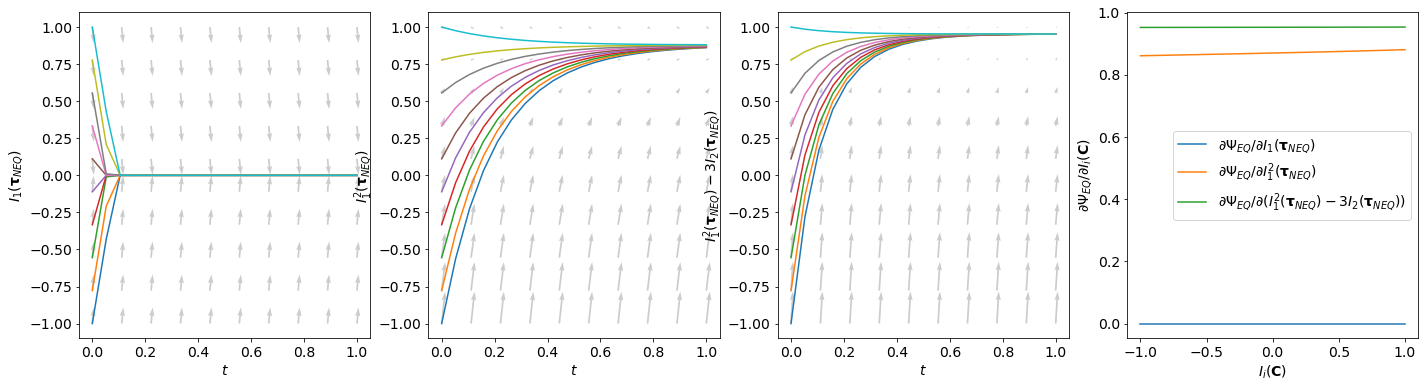

In [448]:
fig, ax = plt.subplots(1,4,figsize=[24,6])

ax[0].quiver(x1,y1,u1,v1, alpha=0.2)
for trajectory in trajectories1:
    ax[0].plot(t, trajectory)
ax[0].set(xlabel='$t$', ylabel=r'$I_1(\mathbf{\tau}_{NEQ})$'); 

ax[1].quiver(x2,y2,u2,v2, alpha=0.2)
for trajectory in trajectories2:
    ax[1].plot(t, trajectory)
ax[1].set(xlabel='$t$', ylabel=r'$I_1^2(\mathbf{\tau}_{NEQ})$'); 

ax[2].quiver(x3,y3,u3,v3, alpha=0.2)
for trajectory in trajectories3:
    ax[2].plot(t, trajectory)
ax[2].set(xlabel='$t$', ylabel=r'$I_1^2(\mathbf{\tau}_{NEQ})-3I_2(\mathbf{\tau}_{NEQ})$'); 

ax[3].plot(trajectories1[:,0], trajectories1[:,-1], label=r'$\partial \Psi_{EQ}/\partial I_1(\mathbf{\tau}_{NEQ})$')
ax[3].plot(trajectories2[:,0], trajectories2[:,-1], label=r'$\partial \Psi_{EQ}/\partial I_1^2(\mathbf{\tau}_{NEQ})$')
ax[3].plot(trajectories3[:,0], trajectories3[:,-1], label=r'$\partial \Psi_{EQ}/\partial (I_1^2(\mathbf{\tau}_{NEQ})-3I_2(\mathbf{\tau}_{NEQ}))$')
ax[3].set(xlabel='$I_i(\mathbf{C})$', ylabel='$\partial \Psi_{EQ}/\partial I_i(\mathbf{C})$')
ax[3].legend(); 

In [618]:
# Save for tikz

# Panel G
header1 = ['x', 'y', 'u', 'v']
a = np.array([x1.flatten(), y1.flatten(), u1.flatten(), v1.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_G_quiver.csv', index=False, sep=' ')

header2 = ['x']
for i in range(10):
    header2.append('y{}'.format(str(i)))
df = pd.DataFrame(np.array([t,*trajectories1]).T, columns=header2)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_G_curves.csv', index=False, sep=' ')

# Panel H
a = np.array([x2.flatten(), y2.flatten(), u2.flatten(), v2.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_H_quiver.csv', index=False, sep=' ')

df = pd.DataFrame(np.array([t,*trajectories2]).T, columns=header2)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_H_curves.csv', index=False, sep=' ')

# Panel I
a = np.array([x3.flatten(), y3.flatten(), u3.flatten(), v3.flatten()])
df = pd.DataFrame(a.T, columns=header1)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_I_quiver.csv', index=False, sep=' ')

df = pd.DataFrame(np.array([t,*trajectories3]).T, columns=header2)
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_I_curves.csv', index=False, sep=' ')

# Panel J
header = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3']
df = pd.DataFrame([trajectories1[:,0], trajectories1[:,-1], trajectories2[:,0], trajectories2[:,-1], trajectories3[:,0], trajectories3[:,-1]]).T
df.columns = header
df.to_csv('tikz_data/fig_odetrj_data/fig_odetrj_J.csv', index=False, sep=' ')